1.	Classer les scores en rang (les scores bruts deviennent des rangs classés du plus petit au plus grand)
2.	Transforme les rangs en quantiles normaux (la constante c varie selon la méthode :  Rankit est utilisé ici) On convertit chaque rang en une probabilité cumulative puis on applique l’inverse de la fonction normale standard
3.	Resclaling en scaled score (mean = 10, standard deviation = 3) 


Flanker 

In [2]:

from neurostatx.io.loader import DatasetLoader

df = DatasetLoader()

# Import Flanker data frame
df.load_data("c:/Users/Rosalie/OneDrive - Office 365/Documents/UdeS/Hiver 2026/Crédits de recherche/data/PINGTabularData/flanker01.txt")
flankerdf = df.get_data()[df.get_data().iloc[1:].dropna(axis=1, how="all").columns]

In [3]:
# Étape 1 : classer les scores en rang

import pandas as pd

# On crée une copie pour ne pas modifier le dataframe de base
flankerdata = flankerdf.copy()

# Mettre les colonnes "interview_age" et "nih_flanker_computed" en numérique
flankerdata.loc[:, "age_months"] = pd.to_numeric(flankerdata["interview_age"], errors="coerce")
flankerdata.loc[:, "nih_flanker_computed"] = pd.to_numeric(flankerdata["nih_flanker_computed"], errors="coerce")

# exclure les participants de moins de 36 mois (3 ans)
flanker_ranked = flankerdata.loc[:, ["subjectkey", "age_months", "nih_flanker_computed"]].iloc[1:].copy()
flanker_ranked = flanker_ranked.loc[flanker_ranked["age_months"] >= 36].copy()

# Création d'une nouvelle colonne "rank"
flanker_ranked.loc[:, "rank"] = flanker_ranked["nih_flanker_computed"].rank(method="average")



In [4]:
# Étape 2 : inverse normal transformation (INT) avec Rankit (c=0.5)

import numpy as np
from scipy.stats import norm

# Nombre de valeurs valides (ne compte pas les missings values)
N = flanker_ranked["rank"].notna().sum()
C = 0.5 # Constante de Rankit

# Créer colonne z_score (INT avec Rankit c=0.5)
flanker_ranked["z_score"] = np.nan  # Initialiser la colonne avec des NaN
mask = flanker_ranked["rank"].notna()

# Formule de INT : z = Φ^(-1)((rank - C) / (N + 1 - 2C))
flanker_ranked.loc[mask, "z_score"] = norm.ppf(
    (flanker_ranked.loc[mask, "rank"] - C) / (N + 1 - 2*C)
)


In [5]:
# Étape 3 : scaled score avec mean = 10 et SD = 3

flanker_ranked["scaled_score"] = 10 + 3 * flanker_ranked["z_score"]

print("Mean :", flanker_ranked["scaled_score"].mean())
print("SD   :", flanker_ranked["scaled_score"].std())



Mean : 10.000432962857314
SD   : 2.9981236050662896


Line plot with error bars and polynomial fit \
Y = Normalized Scaled Scores\
X = Age en année


In [6]:
# Arrondir l'age en année ronde

flanker_ranked["age_year"] = (flanker_ranked["age_months"] / 12).astype(int)
flanker_ranked["age_year"].value_counts().sort_index().head()


age_year
3     62
4     73
5     86
6    100
7    105
Name: count, dtype: int64

In [7]:
# Preparer les moyennes par age

import numpy as np

# Grouper par âge
flanker_grouped = (
    flanker_ranked
    .groupby("age_year")["scaled_score"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# Standard Error
flanker_grouped["se"] = flanker_grouped["std"] / np.sqrt(flanker_grouped["count"])

# Erreur ±2 SE
flanker_grouped["error"] = 2 * flanker_grouped["se"]



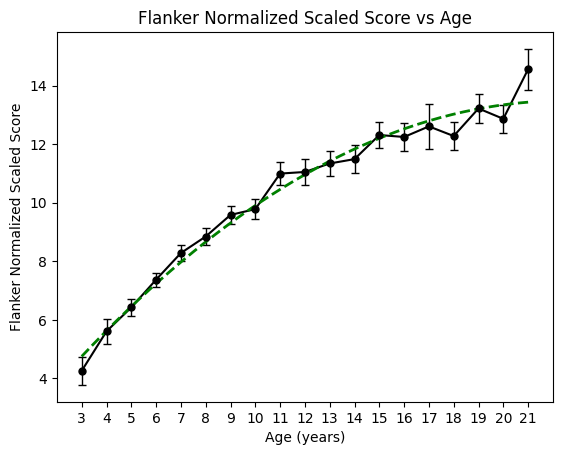

In [8]:
# Creer line plot avec barres d'erreur et courbe polynomial

import matplotlib.pyplot as plt

# Creer la courbe polynomial avec ajustement polynomial degré 2
coeffs = np.polyfit(flanker_grouped["age_year"], flanker_grouped["mean"], 2)
poly = np.poly1d(coeffs)

# Générer des points pour la courbe polynomial
age_range = np.linspace(flanker_grouped["age_year"].min(),
                        flanker_grouped["age_year"].max(), 200)

plt.figure()

# Points + barres d'erreur
plt.errorbar(
    flanker_grouped["age_year"],
    flanker_grouped["mean"],
    yerr=flanker_grouped["error"],
    fmt="o",
    capsize=3,
    color="black",
    ecolor="black",
    elinewidth=1,
    markersize=5
)

# Ligne reliant les points
plt.plot(
    flanker_grouped["age_year"],
    flanker_grouped["mean"],
    color="black",
    linewidth=1.5
)

# Courbe polynomial
plt.plot(age_range, poly(age_range),
          linestyle="--",
            color="green",
              linewidth=2
)

# Titre du graphique et des axes
plt.title("Flanker Normalized Scaled Score vs Age")
plt.xlabel("Age (years)")
plt.ylabel("Flanker Normalized Scaled Score")

# Limites et ticks de l'axe x
plt.xlim(2, 22)
plt.xticks(range(3, 22))

# Sauvegarder le graphique
plt.savefig(
    "Lineplot_Flanker_Normalized_Scaled_Score_vs_Age.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
